In [1]:

%pprint
%matplotlib inline
import sys
import os.path as osp

executable_path = sys.executable; scripts_folder = osp.join(osp.dirname(executable_path), 'Scripts')
py_folder = osp.abspath('../py'); ffmpeg_folder = r'C:\ffmpeg\bin'
if (scripts_folder not in sys.path): sys.path.insert(1, scripts_folder)
if (py_folder not in sys.path): sys.path.insert(1, py_folder)
if (ffmpeg_folder not in sys.path): sys.path.insert(1, ffmpeg_folder)
from jobpostlib import (crf, cu, datetime, duration, hau, hc, humanize, ihu, lru, nu, osp, scrfcu, slrcu, ssgdcu, su, t0, time, wsu, speech_engine)
from pandas import DataFrame
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date, datetime
import matplotlib.dates as mdates

Pretty printing has been turned OFF
======== Neo4j/5.24.2 ========
Utility libraries created in 4 seconds


In [2]:

window = 4
min_periods = 1
rolling_mean = lambda srs: srs.rolling(window=window, min_periods=min_periods).mean()
cumulative_sum = lambda srs: srs.cumsum()
ratio_color = 'green'
def plot_total_data(ax, func):
    ax.plot(
        weekly_activity_df.index,
        func(weekly_activity_df['interview_application_ratio']),
        color=ratio_color
    )

In [3]:

def format_plot(fig, ax):
    
    # Set the y-tick labels to ratios
    y_ticks = ax.get_yticks()
    y_tick_labels = [f"{numerator}/{denominator}" for numerator, denominator in (nu.float_to_ratio(tick) for tick in y_ticks)]
    ax.set_yticklabels(y_tick_labels)
    
    # Set and auto-format the x-axis ticks and label
    ax.set_xlabel('Month')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))
    fig.autofmt_xdate()
    
    # Adjust layout to prevent cutting off labels
    fig.tight_layout()
    ax.grid(True, linestyle='--', alpha=0.7)

In [4]:

from cycler import cycler
import numpy as np

# Periods of unemployment
cycle_fn = cycler('color', plt.cm.Accent(np.linspace(0, 1, 3)))
periods_list = ['October 2020 to December 2020', 'March 2022 to September 2022', 'March 2023 to March 2023', f'June 2024 to {datetime.now().strftime("%B")} 2024']

In [5]:

import calendar

def get_vspan_days(date_range_list):
        
    # Get the first day of the month of the start of the range
    first_day = datetime.strptime(date_range_list[0], '%B %Y').replace(day=1)
    
    # Get the last day of the month of the end of the range
    stop_datetime_obj = datetime.strptime(date_range_list[1], '%B %Y')
    last_day = stop_datetime_obj.replace(day=calendar.monthrange(stop_datetime_obj.year, stop_datetime_obj.month)[1])

    return first_day, last_day

In [6]:

# Cypher for job hunting activity since the beginning of recorded history
cypher_str = cu.get_cypher_for_job_hunting_activity()

# Cypher for job hunting activity since last day of work
# last_day_of_work = datetime(2024, 6, 13)
# cypher_str = cu.get_cypher_for_job_hunting_activity(last_day_of_work=last_day_of_work)

In [7]:

row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
assert row_objs_list, "You are not getting any hunting activity"
hunting_activity_df = DataFrame(row_objs_list).set_index('action_date')

# Convert neo4j.time.Date to Python date
hunting_activity_df.index = [date(d.year, d.month, d.day) for d in hunting_activity_df.index]

# Now convert to datetime
hunting_activity_df.index = pd.to_datetime(hunting_activity_df.index)

In [8]:

mask_series = (hunting_activity_df.total_applications == 0)
hunting_activity_df.loc[~mask_series, 'interview_application_ratio'] = (hunting_activity_df[~mask_series].total_screens + hunting_activity_df[~mask_series].total_interviews) / hunting_activity_df[~mask_series].total_applications
hunting_activity_df.sample(5)

,total_applications,total_rejections,total_screens,total_interviews,interview_application_ratio
2022-08-16,2,0,0,0,0.0
2023-02-11,4,0,0,0,0.0
2024-10-21,3,0,0,0,0.0
2024-08-21,2,0,0,0,0.0
2022-07-22,4,0,0,0,0.0


In [9]:

weekly_activity_df = hunting_activity_df.groupby(pd.Grouper(freq='W')).sum()
mask_series = (weekly_activity_df.total_applications == 0)
weekly_activity_df.loc[~mask_series, 'interview_application_ratio'] = (weekly_activity_df[~mask_series].total_screens + weekly_activity_df[~mask_series].total_interviews) / weekly_activity_df[~mask_series].total_applications
weekly_activity_df.sample(5)

,total_applications,total_rejections,total_screens,total_interviews,interview_application_ratio
2024-03-31,0,0,0,0,0.0
2023-01-08,10,0,0,0,0.0
2023-09-17,0,0,0,0,0.0
2024-02-04,0,0,0,0,0.0
2024-10-13,13,5,0,0,0.0


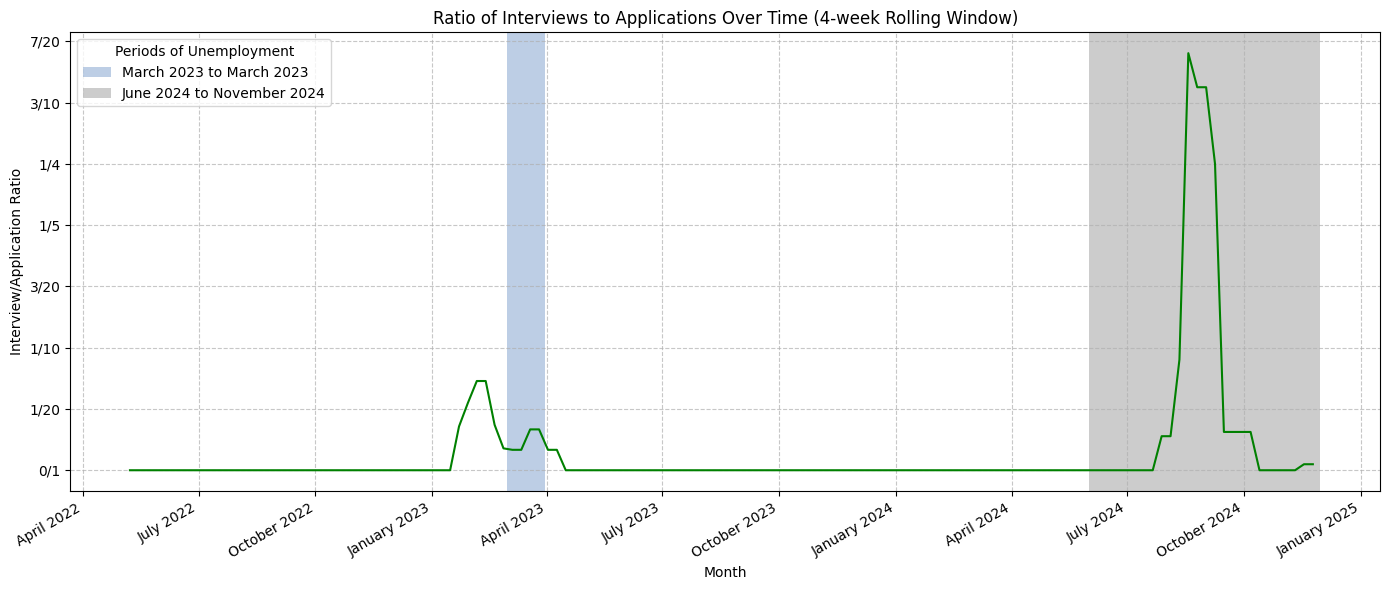

In [11]:

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(14, 6))

# Plot the rolling data
plot_total_data(ax, rolling_mean)

# Customize the plot
ax.set_title(f'Ratio of Interviews to Applications Over Time ({window}-week Rolling Window)')
ax.set_ylabel('Interview/Application Ratio')

# Mark the periods of unemployment
for date_range_str, face_color_dict in zip(periods_list[1:], cycle_fn()):
    face_color = face_color_dict['color']
    date_range_list = date_range_str.split(' to ')
    first_day, last_day = get_vspan_days(date_range_list)
    if first_day >= weekly_activity_df.index.min().replace(day=1):
        ax.axvspan(first_day, last_day, facecolor=face_color, alpha=0.33, label=date_range_str)
ax.legend(title='Periods of Unemployment')

# Format the plot
format_plot(fig, ax)

# Show the plot
plt.show()